In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import os

# Set the MuJoCo rendering environment
os.environ["MUJOCO_GL"] = "glfw"


In [2]:
# Environment Constants
DELTA_T = 0.1
MAX_TIME = 30.0
GOAL_REGION = np.array([0.9, 0.0])  # Goal position (xg, yg)
GOAL_THRESHOLD = 0.1
ACTION_BOUNDS = [-1.0, 1.0]


In [3]:
# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load the MuJoCo model
with open("nav1.xml", 'r') as f:
    xml_string = f.read()
model = mujoco.MjModel.from_xml_string(xml_string)

# Define constants
START_POS = np.array([0.0, 0.0])

# Goal region defined as a square
GOAL_REGION_MIN = np.array([0.8, -0.15])  # Bottom-left corner of the goal square
GOAL_REGION_MAX = np.array([1.0, 0.15])   # Top-right corner of the goal square

LEARNING_RATE = 5e-4

# Obstacles: Define the obstacle as per the environment
OBSTACLES = [
    {'x_min': 0.4, 'x_max': 0.6, 'y_min': -0.15, 'y_max': 0.15}
]


In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 8)
        self.fc2 = nn.Linear(8, 8)
        self.mean = nn.Linear(8, action_dim)
        self.std = nn.Linear(8, action_dim)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = torch.tanh(self.mean(x))
        std = torch.clamp(torch.nn.functional.softplus(self.std(x)), min=0.2, max=2.0)
        return mean, std

In [6]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 8)
        self.fc2 = nn.Linear(8, 8)
        self.value = nn.Linear(8, 1)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.value(x)
        return value

In [7]:
def step(state, action):
    fx, fy = action
    rho_x, rho_y = np.random.normal(0, 0.1, size=2)
    vx, vy = state[2], state[3]
    
    # Update velocity
    vx_new = vx + (fx - rho_x) * DELTA_T
    vy_new = vy + (fy - rho_y) * DELTA_T
    
    # Update position
    x_new = state[0] + vx * DELTA_T
    y_new = state[1] + vy * DELTA_T
    
    next_state = np.array([x_new, y_new, vx_new, vy_new])
    reward = 1 if np.linalg.norm(next_state[:2] - GOAL_REGION) <= GOAL_THRESHOLD else 0
    done = reward == 1 or len(state) * DELTA_T >= MAX_TIME
    return next_state, reward, done

def reset():
    x, y = np.random.uniform(-0.2, 1.1), np.random.uniform(-0.35, 0.35)
    return np.array([x, y, 0.0, 0.0])

In [8]:
# Training Parameters
state_dim = 4
action_dim = 2
actor = Actor(state_dim, action_dim).to(device)
critic = Critic(state_dim).to(device)

# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=LEARNING_RATE)
critic_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

actor.apply(init_weights)
critic.apply(init_weights)

# Training Loop
num_episodes = 1000
max_timesteps = 200
avg_rewards = []

In [9]:
for episode in range(num_episodes):
    state = reset()
    episode_rewards = []
    log_probs = []
    values = []
    
    for t in range(max_timesteps):
        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        
        mean, std = actor(state_tensor)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum()
        value = critic(state_tensor)
        
        action_clipped = action.cpu().numpy().clip(ACTION_BOUNDS[0], ACTION_BOUNDS[1])
        next_state, reward, done = step(state, action_clipped)
        episode_rewards.append(reward)
        log_probs.append(log_prob)
        values.append(value)
        
        if done:
            break
        state = next_state
    
    # Compute Returns
    returns = []
    R = 0
    for r in reversed(episode_rewards):
        R = r + R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    values = torch.cat(values)
    advantages = (returns - values).detach()

    # Update Actor
    actor_loss = -torch.mean(torch.stack(log_probs) * advantages)
    actor_optimizer.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=5.0)
    actor_optimizer.step()
    
    # Update Critic
    critic_loss = torch.mean((returns - values) ** 2)
    critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=5.0)
    critic_optimizer.step()
    
    avg_rewards.append(np.mean(episode_rewards))
    if episode % 50 == 0:
        print(f"Episode {episode}, Average Reward: {np.mean(avg_rewards[-50:])}")


Episode 0, Average Reward: 0.0
Episode 50, Average Reward: 0.03398845598845599
Episode 100, Average Reward: 0.024525252525252526
Episode 150, Average Reward: 0.10515151515151516
Episode 200, Average Reward: 0.06452035886818495
Episode 250, Average Reward: 0.06966346153846154
Episode 300, Average Reward: 0.026681990907709098
Episode 350, Average Reward: 0.06649212430821627
Episode 400, Average Reward: 0.0638211382113821
Episode 450, Average Reward: 0.04377720318896789
Episode 500, Average Reward: 0.018027042140249687
Episode 550, Average Reward: 0.07944444444444444
Episode 600, Average Reward: 0.07819047619047619
Episode 650, Average Reward: 0.026444444444444448
Episode 700, Average Reward: 0.03095238095238095
Episode 750, Average Reward: 0.08205357142857142
Episode 800, Average Reward: 0.03212580010855873
Episode 850, Average Reward: 0.10876262626262627
Episode 900, Average Reward: 0.011803011803011803
Episode 950, Average Reward: 0.007334267040149393


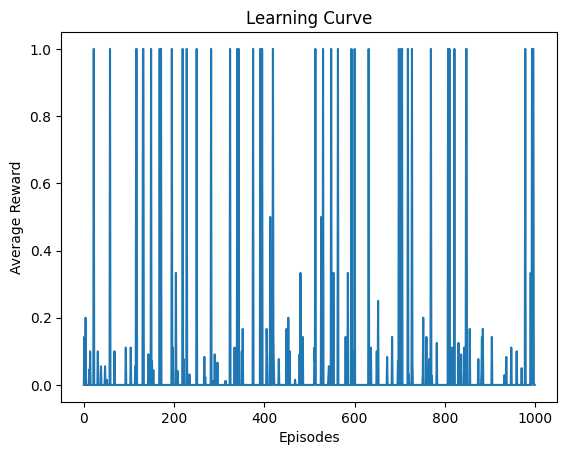

In [ ]:
# Plot the Learning Curve
plt.plot(avg_rewards)
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Learning Curve")
plt.show()

In [ ]:
import numpy as np
from Actor_Critic import Agent
import matplotlib.pyplot as plt
from ball_navigation_env import BallNavigationEnv

# def plot_learning_curve(x, scores, filename):
    
#     running_avg = np.zeros_like(scores)
#     for i in range(len(running_avg)):
#         running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
#     plt.plot(x, running_avg)
#     plt.title('Running Average of Previous 100 Scores')
#     plt.savefig(filename)

# if __name__ == '__main__':
#     env = BallNavigationEnv('nav1.xml')
#     agent = Agent(alpha=0.0003, gamma=0.99, n_actions=env.n_actions)
#     n_games = 1000
#     scores = []

#     for i in range(n_games):
#         observation = env.reset()
#         done = False
#         score = 0
#         while not done:
#             action, log_prob = agent.choose_action(observation)
#             observation_, reward, done = env.step(action)
#             agent.learn(observation, reward, observation_, done, log_prob)
#             observation = observation_
#             score += reward
#         scores.append(score)
#         print(f'Episode {i}, Score: {score}, Avg Score: {np.mean(scores[-100:])}')

#     x = [i+1 for i in range(len(scores))]
#     plot_learning_curve(x, scores, 'learning_curve.png')
#     env.close()




# def plot_learning_curve(x, scores, filename):
#     running_avg = np.zeros_like(scores)
#     for i in range(len(running_avg)):
#         running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
#     plt.plot(x, running_avg)
#     plt.title('Running average of previous 100 scores')
#     plt.xlabel('Episode')
#     plt.ylabel('Score')
#     plt.savefig(filename)
#     plt.close()

# if __name__ == '__main__':
#     env = BallNavigationEnv('nav1.xml')
#     agent = Agent(alpha=0.0003, gamma=0.99, n_actions=env.n_actions)
#     n_games = 1000
#     max_steps = 200  # Maximum steps per episode
#     scores = []

#     for i in range(n_games):
#         observation = env.reset()
#         done = False
#         score = 0
#         step_count = 0
        
#         while not done and step_count < max_steps:
#             action, log_prob = agent.choose_action(observation)
#             observation_, reward, done = env.step(action)
#             agent.learn(observation, reward, observation_, done, log_prob)
#             observation = observation_
#             score += reward
#             step_count += 1
            
#         scores.append(score)
        
#         if (i + 1) % 10 == 0:
#             print(f'Episode {i+1}, Score: {score:.2f}, Average Score: {np.mean(scores[-100:]):.2f}')

#     x = [i+1 for i in range(len(scores))]
#     plot_learning_curve(x, scores, 'learning_curve.png')
#     env.close()


import tensorflow as tf
import tensorflow_probability  as tfp
import numpy as np
import mujoco
import gymnasium as gym
from gymnasium import spaces
import time

class RobotEnvironment(gym.Env):
    def __init__(self, model_path):
        super().__init__()
        
        # Load MuJoCo model
        self.model = mujoco.MjModel.from_xml_path(model_path)
        self.data = mujoco.MjData(self.model)
        
        # Define action and observation spaces
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
        
        # Set goal position (can be modified as needed)
        self.goal_position = np.array([0.9, 0.0])  # Matching the target4 position in MuJoCo model
        self.goal_threshold = 0.1  # Epsilon for goal reaching
        self.dt = 0.1  # Time step
        
    def reset(self, seed=None):
        super().reset(seed=seed)
        
        # Random initial position
        init_x = np.random.uniform(-0.1, 1.0)
        init_y = np.random.uniform(-0.3, 0.3)
        
        # Reset MuJoCo simulation
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0] = init_x
        self.data.qpos[1] = init_y
        self.data.qvel[:] = 0.0
        
        return self._get_obs(), {}
    
    def _get_obs(self):
        pos = self.data.qpos[:2]
        vel = self.data.qvel[:2]
        return np.concatenate([pos, vel])
    
    def step(self, action):
        # Apply action forces with noise
        noise_x = np.random.normal(0, 0.1)
        noise_y = np.random.normal(0, 0.1)
        
        self.data.ctrl[0] = action[0] + noise_x
        self.data.ctrl[1] = action[1] + noise_y
        
        # Step simulation
        mujoco.mj_step(self.model, self.data)
        
        # Get new state
        obs = self._get_obs()
        
        # Calculate reward
        dist_to_goal = np.linalg.norm(obs[:2] - self.goal_position)
        reward = 1.0 if dist_to_goal <= self.goal_threshold else 0.0
        
        # Check if done
        done = False  # Episode continues until time limit
        
        return obs, reward, done, False, {}

class ActorCritic(tf.keras.Model):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.action_dim = action_dim
        
        # Actor network (policy)
        self.actor = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(state_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(action_dim * 2)  # Mean and log_std
        ])
        
        # Critic network (value function)
        self.critic = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(state_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    def get_action(self, state):
        """Get action and its parameters from the current policy."""
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        action_params = self.actor(state_tensor)[0]  # Get first batch item
        
        # Split into means and log_stds
        means, log_stds = tf.split(action_params, 2)
        stds = tf.exp(log_stds)
        
        # Sample from normal distribution
        dist = tfp.distributions.Normal(means, stds)
        actions = dist.sample()
        
        # Clip actions to [-1, 1]
        actions = tf.clip_by_value(actions, -1.0, 1.0)
        
        return actions.numpy(), means.numpy(), stds.numpy()
    
    def get_value(self, state):
        """Get value estimate for the given state."""
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        return self.critic(state_tensor)[0, 0]

    def get_action_params(self, state):
        """Get the raw action parameters (means and log_stds)."""
        action_params = self.actor(state)
        means, log_stds = tf.split(action_params, 2, axis=-1)
        return means, log_stds

def train_ac(env, model, episodes=1000, max_steps=200):
    optimizer_actor = tf.keras.optimizers.Adam(learning_rate=0.001)
    optimizer_critic = tf.keras.optimizers.Adam(learning_rate=0.001)
    gamma = 0.99
    
    episode_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # Convert state to tensor
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
            
            # Get action and value
            action, action_mean, action_std = model.get_action(state)
            value = model.get_value(state)
            
            # Take action in environment
            next_state, reward, done, _, _ = env.step(action)
            next_state_tensor = tf.convert_to_tensor([next_state], dtype=tf.float32)
            
            episode_reward += reward
            
            # Get next state value
            next_value = model.get_value(next_state)
            
            # Calculate TD error
            td_target = reward + gamma * next_value * (1 - float(done))
            td_error = td_target - value
            
            # Update networks
            with tf.GradientTape() as tape_actor:
                action_params = model.actor(state_tensor)
                means, log_stds = tf.split(action_params, 2, axis=-1)
                stds = tf.exp(log_stds)
                
                # Create normal distribution
                dist = tfp.distributions.Normal(means, stds)
                
                # Calculate log probability of taken action
                action_tensor = tf.convert_to_tensor([action], dtype=tf.float32)
                log_prob = tf.reduce_sum(dist.log_prob(action_tensor), axis=-1)
                
                # Calculate actor loss with reduction
                actor_loss = -tf.reduce_mean(log_prob * tf.stop_gradient(td_error))
            
            with tf.GradientTape() as tape_critic:
                value_pred = model.critic(state_tensor)
                # Calculate critic loss with reduction
                critic_loss = tf.reduce_mean(tf.square(td_target - value_pred))
            
            # Calculate and apply gradients
            actor_grads = tape_actor.gradient(actor_loss, model.actor.trainable_variables)
            critic_grads = tape_critic.gradient(critic_loss, model.critic.trainable_variables)
            
            # Debug prints
            print(f"Actor loss: {actor_loss.numpy()}")
            print(f"Critic loss: {critic_loss.numpy()}")
            print(f"TD error: {td_error.numpy()}")
            
            # Check if gradients exist
            if None in actor_grads:
                print("Warning: Some actor gradients are None!")
            if None in critic_grads:
                print("Warning: Some critic gradients are None!")
                
            optimizer_actor.apply_gradients(zip(actor_grads, model.actor.trainable_variables))
            optimizer_critic.apply_gradients(zip(critic_grads, model.critic.trainable_variables))
            
            state = next_state
            if done:
                break
        
        episode_rewards.append(episode_reward)
        
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}, Average Reward (last 10): {avg_reward:.2f}")
    
    return episode_rewards

# Main execution
def main():
    # Initialize environment and model
    env = RobotEnvironment("Nav1.xml")
    model = ActorCritic(state_dim=4, action_dim=2)
    
    # Train the model
    rewards = train_ac(env, model)
    
    # Plot learning curve
    import matplotlib.pyplot as plt
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Learning Curve')
    plt.savefig('learning_curve.png')
    plt.close()

if __name__ == "__main__":
    main()